# Models

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
pd.set_option('display.max_columns', 500)
plt.rcParams["figure.figsize"] = (10,7)

import sys
sys.path.append('../')

from src.utils import read_pickle, save_to_pickle, kmeans_elbow
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score

### Loading data

In [16]:
target_column = "amount_spent_1m"
df_train = pd.read_csv("../data/df_train.csv")
df_dev = pd.read_csv("../data/df_dev.csv")
df_test = pd.read_csv("../data/df_test.csv")

X_train = df_train.drop(columns=target_column)
X_dev = df_dev.drop(columns=target_column)
X_test = df_test.drop(columns=target_column)

y_train = df_train[target_column].values
y_test = df_test[target_column].values
y_dev = df_dev[target_column].values

predictor_columns = X_train.columns.tolist()

### Centering Data

In [17]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=predictor_columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=predictor_columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=predictor_columns)

### Clustering

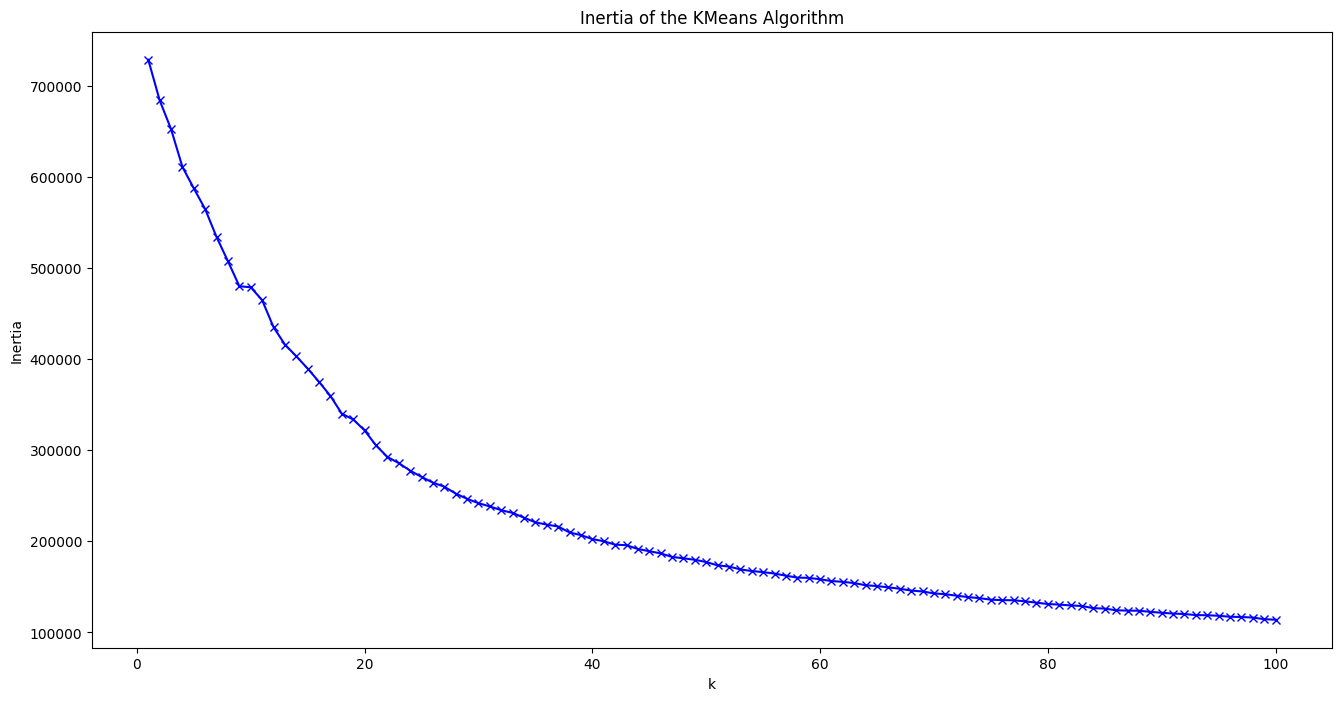

In [18]:
kmeans_elbow(X_train, max_clusters=100)

In [19]:
km = KMeans(n_clusters=20, random_state=42)

km.fit(X_train)

clusters = km.labels_

df_train["cluster"] = clusters

X_train["cluster"] = clusters
X_dev["cluster"] = km.predict(X_dev)
X_test["cluster"] = km.predict(X_test)

### Results of clustering

In [21]:
df_clusters_info_1 = X_train.groupby("cluster").size().sort_values().reset_index(name="counting")
df_clusters_info_2 = df_train.groupby("cluster").agg(**{
    f"median_{target_column}" : (target_column, "median"),
    "median_amount_current_month" : ('amount_spent', "median")
})
df_clusters_info_1 = df_clusters_info_1.merge(df_clusters_info_2, on="cluster")
df_clusters_info_1["cumulated_poblation"] = df_clusters_info_1["counting"].cumsum() / len(X_train) 
df_clusters_info_1

,cluster,counting,median_amount_spent_1m,median_amount_current_month,cumulated_poblation
0,1,1,4063.000,41666.000,0.000055
1,5,1,8124.370,448520.720,0.000110
2,6,1,17063.090,429606.940,0.000165
3,8,1,449.760,560870.830,0.000220
4,3,2,110880.415,97710.860,0.000330
5,14,2,455.000,23702.715,0.000439
6,18,6,3801.480,8159.180,0.000769
7,9,9,57794.950,57794.950,0.001263
8,12,11,10668.550,15790.310,0.001867
9,7,13,18373.690,16379.700,0.002581


In [22]:
print(f"Target mediana: {df_train[target_column].median() : .2f}")

Target mediana:  91.05


### Suspicious profiles:

In [23]:
small_clusters = X_train.groupby("cluster").size().sort_values().index[:13].tolist()

index_small_clusters = X_train[X_train.cluster.isin(small_clusters)].index

display(df_train.loc[index_small_clusters].head(50))

,amount_spent,sum_original_gross_amt_schools,count_1,count_2,count_3,count_4,count_5,count_6,count_schools,count_7,count_8,count_9,days_since_last_purchase,sum_original_gross_amt_1,sum_original_gross_amt_2,sum_original_gross_amt_3,sum_original_gross_amt_4,sum_original_gross_amt_5,sum_original_gross_amt_6,sum_original_gross_amt_7,sum_original_gross_amt_8,sum_original_gross_amt_9,sum_original_gross_amt_neighbourhoods,count_neighbourhoods,sum_original_gross_amt_city_operations,count_city_operations,count_0,sum_original_gross_amt_0,count_education_and_skills,sum_original_gross_amt_education_and_skills,sum_original_gross_amt_finance_and_governance,count_finance_and_governance,sum_original_gross_amt_digital_and_customer_services,count_digital_and_customer_services,sum_original_gross_amt_adult_social_care,count_adult_social_care,sum_original_gross_amt_city_housing,count_city_housing,count_inclusive_growth,sum_original_gross_amt_inclusive_growth,amount_spent_1m,cluster
146,9258.08,9258.08,3.0,4.0,104.0,7.0,3.0,4.0,135.0,4.0,1.0,5.0,0,252.01,294.37,5338.92,1261.01,227.30,528.08,1094.14,96.00,166.25,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,797.14,18
157,6342.86,6342.86,2.0,1.0,82.0,1.0,4.0,3.0,97.0,4.0,0.0,0.0,0,239.63,10.80,3223.18,90.28,118.51,1592.23,1068.23,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,10589.99,18
158,10589.99,10589.99,2.0,0.0,188.0,1.0,7.0,8.0,208.0,1.0,0.0,1.0,8,564.95,0.00,7275.43,96.25,381.77,2203.74,43.26,0.00,24.59,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,2809.53,18
165,7060.28,7060.28,2.0,0.0,104.0,4.0,11.0,0.0,131.0,6.0,0.0,4.0,0,398.00,0.00,5273.52,438.00,422.63,0.00,301.36,0.00,226.77,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,6687.82,18
169,6630.19,6630.19,3.0,0.0,103.0,1.0,18.0,1.0,137.0,4.0,3.0,4.0,0,390.39,0.00,5001.14,60.44,428.09,90.20,266.32,251.00,142.61,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,4793.43,18
679,4485.41,0.00,5.0,3.0,0.0,1.0,0.0,2.0,0.0,2.0,1.0,6.0,1,650.68,1291.85,0.00,16.40,0.00,964.52,925.50,14.40,403.98,0.00,0.0,0.0,0.0,2.0,218.08,22.0,4485.41,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,1893.23,17
683,1998.68,0.00,2.0,4.0,0.0,0.0,0.0,2.0,0.0,6.0,2.0,4.0,2,159.45,193.88,0.00,0.00,0.00,114.98,353.57,892.00,284.80,0.00,0.0,0.0,0.0,0.0,0.00,20.0,1998.68,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,1910.83,17
1220,560870.83,0.00,11.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0,559807.08,0.00,0.00,13.75,0.00,0.00,0.00,0.00,1050.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,560870.83,15.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,449.76,8
1243,26489.38,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,26489.38,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,26489.38,2.0,0.0,0.0,0.0,0.00,0.00,14
2734,18327.17,18327.17,3.0,3.0,79.0,5.0,11.0,9.0,140.0,19.0,2.0,9.0,4,1876.27,1486.12,3785.05,2453.29,419.85,1457.78,3207.37,970.09,2671.35,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,783.49,18


### Models

In [24]:
# one hot encoding
def one_hot(X):
    one_hot = pd.get_dummies(X["cluster"]).astype(int)
    X.drop("cluster", inplace=True, axis=1)
    X = X.join(one_hot)

In [25]:
one_hot(X_train)
one_hot(X_dev)
one_hot(X_test)

In [26]:
X = pd.concat([X_train, X_dev]).reset_index(drop=True)
y = np.concatenate([y_train, y_dev])

n_train = len(X_train)
n_dev = len(X_dev)

test_fold = np.repeat(-1, n_train).tolist() + np.repeat(0, n_dev).tolist() 
ps = PredefinedSplit(test_fold)

In [27]:
%%time

# we try to use the xgb model

param_grid = {
    "n_estimators" : np.arange(1, 200, 5), 
    "learning_rate" : np.linspace(0.01, .3, 100),
    "gamma" : np.linspace(0, 5, 100),
    "max_depth" : np.arange(1, 20, 1)
}

model = xgb.XGBRegressor()

# grid_search = RandomizedSearchCV(model, param_grid, cv=ps, random_state=42, n_iter=500, return_train_score=True, scoring="r2")

# ~11min 34s
# grid_search.fit(X, y) 
# save_to_pickle(grid_search, "../data/grid_search.pkl")

grid_search = read_pickle("../data/grid_search.pkl")

CPU times: total: 0 ns
Wall time: 8.68 ms


In [28]:
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv("../data/xgb_random_grid_search.csv", index=False)

In [29]:
mask = np.abs(results["mean_train_score"] - results["mean_test_score"]) < 0.05
results[mask].sort_values("mean_test_score", ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
440,0.124862,0.0,0.007563,0.0,81,3,0.062727,2.676768,"{'n_estimators': 81, 'max_depth': 3, 'learning...",0.657641,0.657641,0.0,6,0.706321,0.706321,0.0
123,0.085058,0.0,0.007579,0.0,56,2,0.147677,4.444444,"{'n_estimators': 56, 'max_depth': 2, 'learning...",0.577839,0.577839,0.0,199,0.610253,0.610253,0.0
161,0.065936,0.0,0.005549,0.0,36,2,0.159394,2.727273,"{'n_estimators': 36, 'max_depth': 2, 'learning...",0.564659,0.564659,0.0,236,0.553624,0.553624,0.0
199,0.153135,0.0,0.006003,0.0,191,1,0.291212,2.525253,"{'n_estimators': 191, 'max_depth': 1, 'learnin...",0.504767,0.504767,0.0,336,0.480045,0.480045,0.0
308,0.039226,0.0,0.007578,0.0,1,2,0.153535,3.737374,"{'n_estimators': 1, 'max_depth': 2, 'learning_...",0.100122,0.100122,0.0,479,0.081077,0.081077,0.0


In [30]:
best_params = results[mask].sort_values("mean_test_score", ascending=False).iloc[0]["params"]

In [31]:
best_params

{'n_estimators': 81,
 'max_depth': 3,
 'learning_rate': 0.06272727272727271,
 'gamma': 2.676767676767677}

In [32]:
model = xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2.676767676767677, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06272727272727271,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=81, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Metricas

In [34]:
y_train_pred = model.predict(X_train)
y_dev_pred = model.predict(X_dev)
y_test_pred = model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_dev = r2_score(y_dev, y_dev_pred)
r2_test = r2_score(y_test, y_test_pred)

In [36]:
print(f"R2 cuadrado en train: {r2_train * 100 : .2f}%")
print(f"R2 cuadrado en dev: {r2_dev * 100 : .2f}%")
print(f"R2 cuadrado en test: {r2_test * 100 : .2f}%")

R2 cuadrado en train:  76.29%
R2 cuadrado en dev:  64.67%
R2 cuadrado en test:  34.35%
